<a href="https://colab.research.google.com/github/zxcasd945/Pytorchcolab/blob/main/06_Pytorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...


In [ ]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.
  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.
  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Overwriting going_modular/data_setup.py


In [ ]:
%%writefile going_modular/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.
    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/
    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.block_2(self.block_1(x))) # <- leverage the benefits of operator fusion


Overwriting going_modular/model_builder.py


In [ ]:
%%writefile going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.
    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).
    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.
    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.
    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    Calculates, prints and stores evaluation metrics throughout.
    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Overwriting going_modular/engine.py


In [ ]:
%%writefile going_modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.
    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting going_modular/utils.py


In [ ]:
%%writefile train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import argparse

import torch

from torchvision import transforms

from going_modular import data_setup, engine, model_builder, utils

# Create a parser
parser = argparse.ArgumentParser(description="Get some hyperparameters.")

# Get an arg for num_epochs
parser.add_argument("--num_epochs",
                     default=10,
                     type=int,
                     help="the number of epochs to train for")

# Get an arg for batch_size
parser.add_argument("--batch_size",
                    default=32,
                    type=int,
                    help="number of samples per batch")

# Get an arg for hidden_units
parser.add_argument("--hidden_units",
                    default=10,
                    type=int,
                    help="number of hidden units in hidden layers")

# Get an arg for learning_rate
parser.add_argument("--learning_rate",
                    default=0.001,
                    type=float,
                    help="learning rate to use for model")

# Create an arg for training directory
parser.add_argument("--train_dir",
                    default="data/pizza_steak_sushi/train",
                    type=str,
                    help="directory file path to training data in standard image classification format")

# Create an arg for test directory
parser.add_argument("--test_dir",
                    default="data/pizza_steak_sushi/test",
                    type=str,
                    help="directory file path to testing data in standard image classification format")

# Get our arguments from the parser
args = parser.parse_args()

# Setup hyperparameters
NUM_EPOCHS = args.num_epochs
BATCH_SIZE = args.batch_size
HIDDEN_UNITS = args.hidden_units
LEARNING_RATE = args.learning_rate
print(f"[INFO] Training a model for {NUM_EPOCHS} epochs with batch size {BATCH_SIZE} using {HIDDEN_UNITS} hidden units and a learning rate of {LEARNING_RATE}")

# Setup directories
train_dir = args.train_dir
test_dir = args.test_dir
print(f"[INFO] Training data file: {train_dir}")
print(f"[INFO] Testing data file: {test_dir}")

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")

Overwriting train.py


In [ ]:
!python train.py --num_epochs 5 --batch_size 128 --hidden_units 128 --learning_rate 0.0003

[INFO] Training a model for 5 epochs with batch size 128 using 128 hidden units and a learning rate of 0.0003
[INFO] Training data file: data/pizza_steak_sushi/train
[INFO] Testing data file: data/pizza_steak_sushi/test
  0% 0/5 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.1056 | train_acc: 0.3201 | test_loss: 1.0993 | test_acc: 0.3467
 20% 1/5 [00:02<00:08,  2.14s/it]Epoch: 2 | train_loss: 1.0893 | train_acc: 0.4388 | test_loss: 1.0834 | test_acc: 0.4000
 40% 2/5 [00:03<00:05,  1.93s/it]Epoch: 3 | train_loss: 1.0724 | train_acc: 0.5037 | test_loss: 1.0551 | test_acc: 0.4667
 60% 3/5 [00:05<00:03,  1.87s/it]Epoch: 4 | train_loss: 1.0407 | train_acc: 0.5173 | test_loss: 1.0292 | test_acc: 0.3600
 80% 4/5 [00:07<00:01,  1.83s/it]Epoch: 5 | train_loss: 0.9911 | train_acc: 0.5416 | test_loss: 0.9971 | test_acc: 0.4000
100% 5/5 [00:10<00:00,  2.07s/it]
[INFO] Saving model to: models/05_going_modular_script_mode_tinyvgg_model.pth


In [ ]:
%%writefile going_modular/predict.py
import torch
import torchvision
import argparse

import model_builder

# Creating a parser
parser = argparse.ArgumentParser()

# Get an image path
parser.add_argument("--image",
                    help="target image filepath to predict on")

# Get a model path
parser.add_argument("--model_path",
                    default="models/05_going_modular_script_mode_tinyvgg_model.pth",
                    type=str,
                    help="target model to use for prediction filepath")

args = parser.parse_args()

# Setup class names
class_names = ["pizza", "steak", "sushi"]

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Get the image path
IMG_PATH = args.image
print(f"[INFO] Predicting on {IMG_PATH}")

# Function to load in the model
def load_model(filepath=args.model_path):
  # Need to use same hyperparameters as saved model
  model = model_builder.TinyVGG(input_shape=3,
                                hidden_units=128,
                                output_shape=3).to(device)

  print(f"[INFO] Loading in model from: {filepath}")
  # Load in the saved model state dictionary from file
  model.load_state_dict(torch.load(filepath))

  return model

# Function to load in model + predict on select image
def predict_on_image(image_path=IMG_PATH, filepath=args.model_path):
  # Load the model
  model = load_model(filepath)

  # Load in the image and turn it into torch.float32 (same type as model)
  image = torchvision.io.read_image(str(IMG_PATH)).type(torch.float32)

  # Preprocess the image to get it between 0 and 1
  image = image / 255.

  # Resize the image to be the same size as the model
  transform = torchvision.transforms.Resize(size=(64, 64))
  image = transform(image)

  # Predict on image
  model.eval()
  with torch.inference_mode():
    # Put image to target device
    image = image.to(device)

    # Get pred logits
    pred_logits = model(image.unsqueeze(dim=0)) # make sure image has batch dimension (shape: [batch_size, height, width, color_channels])

    # Get pred probs
    pred_prob = torch.softmax(pred_logits, dim=1)

    # Get pred labels
    pred_label = torch.argmax(pred_prob, dim=1)
    pred_label_class = class_names[pred_label]

  print(f"[INFO] Pred class: {pred_label_class}, Pred prob: {pred_prob.max():.3f}")

if __name__ == "__main__":
  predict_on_image()

Overwriting going_modular/predict.py


In [ ]:
!python going_modular/predict.py --image data/pizza_steak_sushi/test/sushi/175783.jpg

[INFO] Predicting on data/pizza_steak_sushi/test/sushi/175783.jpg
[INFO] Loading in model from: models/05_going_modular_script_mode_tinyvgg_model.pth
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[INFO] Pred class: pizza, Pred prob: 0.443


In [ ]:
#Above is the modules from previous chapter, 06 will start from this line below-------------------

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7be0d64d3160>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)


In [ ]:
model_0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
##torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6311 | train_acc: 0.7734 | test_loss: 0.5392 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.5903 | train_acc: 0.7578 | test_loss: 0.5128 | test_acc: 0.8968
Epoch: 3 | train_loss: 0.5485 | train_acc: 0.8008 | test_loss: 0.5512 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.5042 | train_acc: 0.8203 | test_loss: 0.4975 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.4842 | train_acc: 0.9336 | test_loss: 0.4700 | test_acc: 0.8968
[INFO] Total training time: 13.377 seconds


In [ ]:
for batch,(X,y) in enumerate(test_dataloader):
  print(X[0].shape)


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([2, 0, 2, 1, 0, 2, 1, 1, 2, 0, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1,
        2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0,
        0, 1, 0])

In [ ]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

test_preds=torch.cat(test_preds).cpu()
print(test_preds)

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([2, 0, 2, 1, 0, 2, 1, 1, 2, 0, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1,
        2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0,
        0, 1, 0])


In [ ]:
from ast import Pass
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list=[]
  for path in test_paths:
    pred_dict= {}
    pred_dict['image_path'] = path
    pred_dict['class'] = path.parent.stem


    from PIL import Image
    img = Image.open(path)
    img=transform(img).unsqueeze(dim=0)

    model.eval()
    with torch.inference_mode():
      test_pred_logits = model(img.to(device))
      test_pred_probs = torch.softmax(test_pred_logits, dim=1)
      test_pred_label = torch.argmax(test_pred_probs, dim=1)
      pred_class= class_names[test_pred_label]
      pred_dict['pred_prob'] = test_pred_probs.squeeze(dim=0).max().cpu().item()
      pred_dict['pred_class'] = pred_class
      pred_dict["Correct"] = path.parent.stem == pred_class
      #if pred_class == path.parent.stem:
        #pass
      #else:
        #pred_dict['Correct'] = 'False'


      test_pred_list.append(pred_dict)
  return test_pred_list



In [ ]:
model_results = pred_and_store(test_data_paths, model_0, simple_transform, class_names, device)

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(model_results)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["Correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

image_path  class  pred_prob  \
54  data/pizza_steak_sushi/test/sushi/1680893.jpg  sushi   0.521572   
72  data/pizza_steak_sushi/test/sushi/2276986.jpg  sushi   0.487564   
16   data/pizza_steak_sushi/test/steak/100274.jpg  steak   0.473869   
4     data/pizza_steak_sushi/test/steak/27415.jpg  steak   0.468252   
66  data/pizza_steak_sushi/test/sushi/1987407.jpg  sushi   0.458377   

   pred_class  Correct  
54      pizza    False  
72      pizza    False  
16      sushi    False  
4       pizza    False  
66      pizza    False

54
72
16
4
66


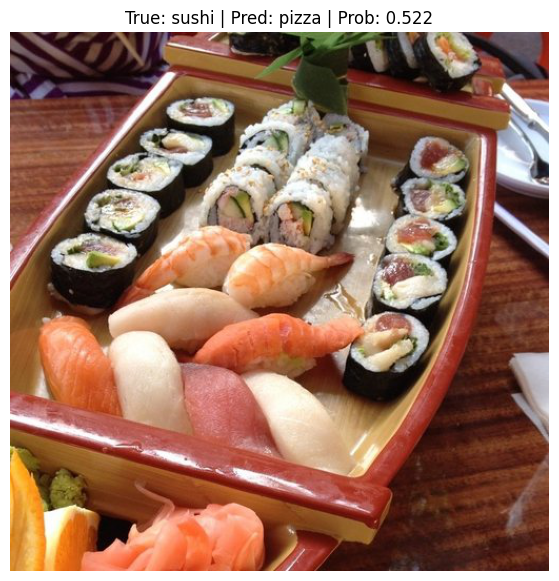

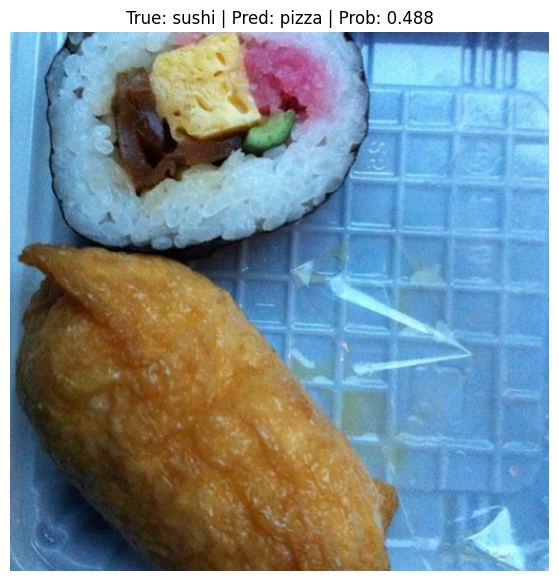

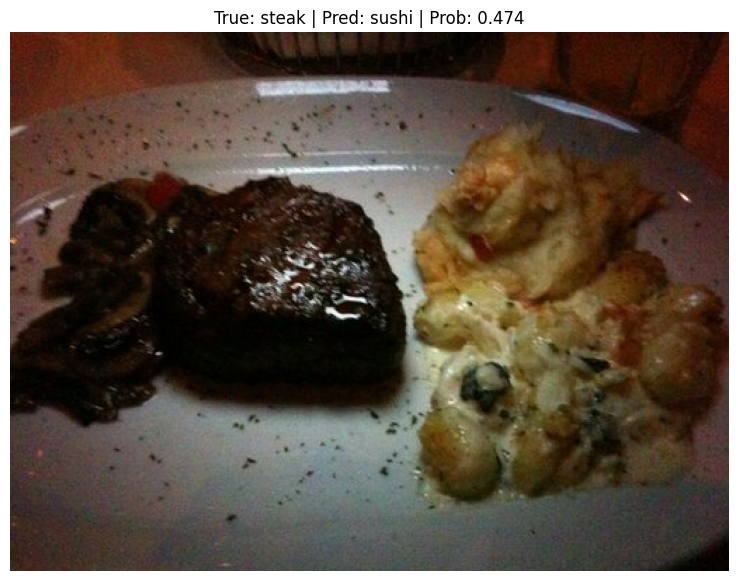

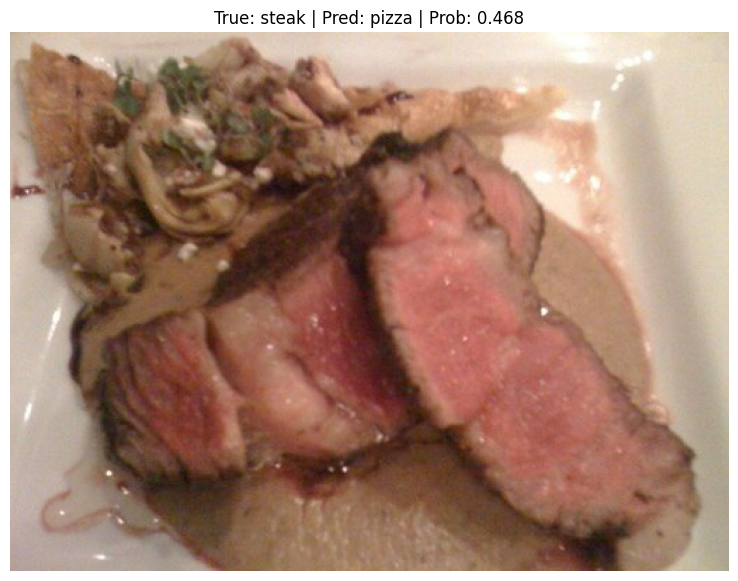

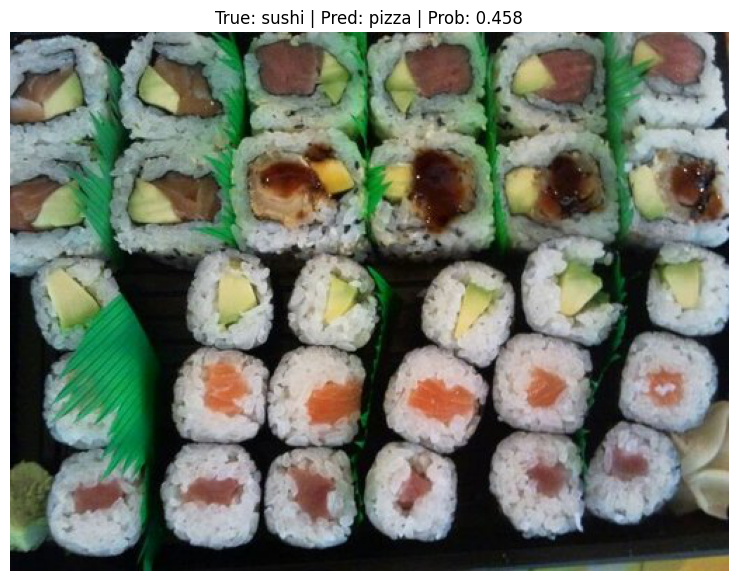

In [ ]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images



for row in top_5_most_wrong.iterrows():
  rx = row[0]
  print(rx)
  row = row[1]
  image_path = str(row[0])
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  from PIL import Image
  img = Image.open(image_path)
  plt.figure(figsize=(10,7))
  plt.imshow(img)
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False)


In [ ]:
#get an pizza image from a random website
!wget https://images.unsplash.com/photo-1594007654729-407eedc4be65



--2023-07-20 08:33:30--  https://images.unsplash.com/photo-1594007654729-407eedc4be65
Resolving images.unsplash.com (images.unsplash.com)... 199.232.150.208, 2a04:4e42:65::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.150.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1991326 (1.9M) [image/jpeg]
Saving to: ‘photo-1594007654729-407eedc4be65.3’

photo-1594007654729 100%[===================>]   1.90M  --.-KB/s    in 0.02s   

2023-07-20 08:33:30 (85.4 MB/s) - ‘photo-1594007654729-407eedc4be65.3’ saved [1991326/1991326]



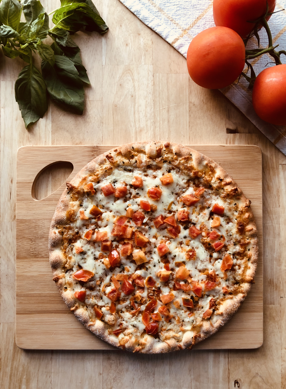

In [ ]:
from PIL import Image
with Image.open('/content/photo-1594007654729-407eedc4be65') as img:
  (width, height) = (img.width//10, img.height//10)
  img_resized = img.resize((width, height))
img_resized.show()


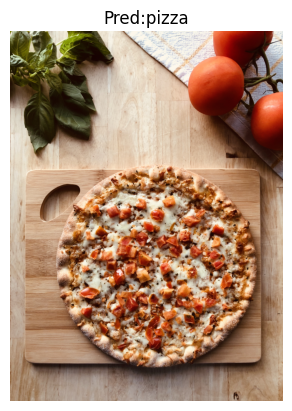

In [ ]:
import matplotlib.pyplot as plt

def pred_and_plot(image_path, model, transform, class_names, device=device):
  model.eval()
  with torch.inference_mode():
    img = Image.open(image_path)
    img_transform = transform(img)
    pred_logits=model(img_transform.unsqueeze(0).to(device))
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_label = torch.argmax(pred_probs, dim=1)
    pred_class = class_names[pred_label]
    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred:{pred_class}')
    plt.axis(False)
pred_and_plot(image_path='/content/photo-1594007654729-407eedc4be65',
              model=model_0,
              transform = simple_transform,
              class_names = class_names,
              device = device
            )

--2023-07-20 08:33:34--  https://images.unsplash.com/photo-1544982503-9f984c14501a
Resolving images.unsplash.com (images.unsplash.com)... 199.232.150.208, 2a04:4e42:65::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.150.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1374287 (1.3M) [image/jpeg]
Saving to: ‘photo-1544982503-9f984c14501a.2’

photo-1544982503-9f 100%[===================>]   1.31M  --.-KB/s    in 0.02s   

2023-07-20 08:33:34 (66.4 MB/s) - ‘photo-1544982503-9f984c14501a.2’ saved [1374287/1374287]



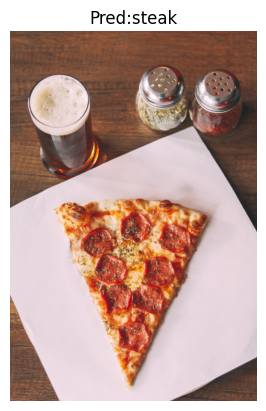

In [ ]:
!wget https://images.unsplash.com/photo-1544982503-9f984c14501a

pred_and_plot(image_path='/content/photo-1544982503-9f984c14501a',
              model=model_0,
              transform = simple_transform,
              class_names = class_names,
              device = device
            )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0541 | train_acc: 0.3789 | test_loss: 0.8630 | test_acc: 0.8248
Epoch: 2 | train_loss: 0.9484 | train_acc: 0.5820 | test_loss: 0.7082 | test_acc: 0.8239
Epoch: 3 | train_loss: 0.7791 | train_acc: 0.7383 | test_loss: 0.6974 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.6778 | train_acc: 0.9141 | test_loss: 0.6272 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6157 | train_acc: 0.8984 | test_loss: 0.5980 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.6139 | train_acc: 0.7891 | test_loss: 0.5911 | test_acc: 0.8456
Epoch: 7 | train_loss: 0.5522 | train_acc: 0.8906 | test_loss: 0.5188 | test_acc: 0.8968
Epoch: 8 | train_loss: 0.5829 | train_acc: 0.7656 | test_loss: 0.4742 | test_acc: 0.8655
Epoch: 9 | train_loss: 0.4674 | train_acc: 0.9375 | test_loss: 0.4463 | test_acc: 0.8864
Epoch: 10 | train_loss: 0.4825 | train_acc: 0.8320 | test_loss: 0.4937 | test_acc: 0.8873


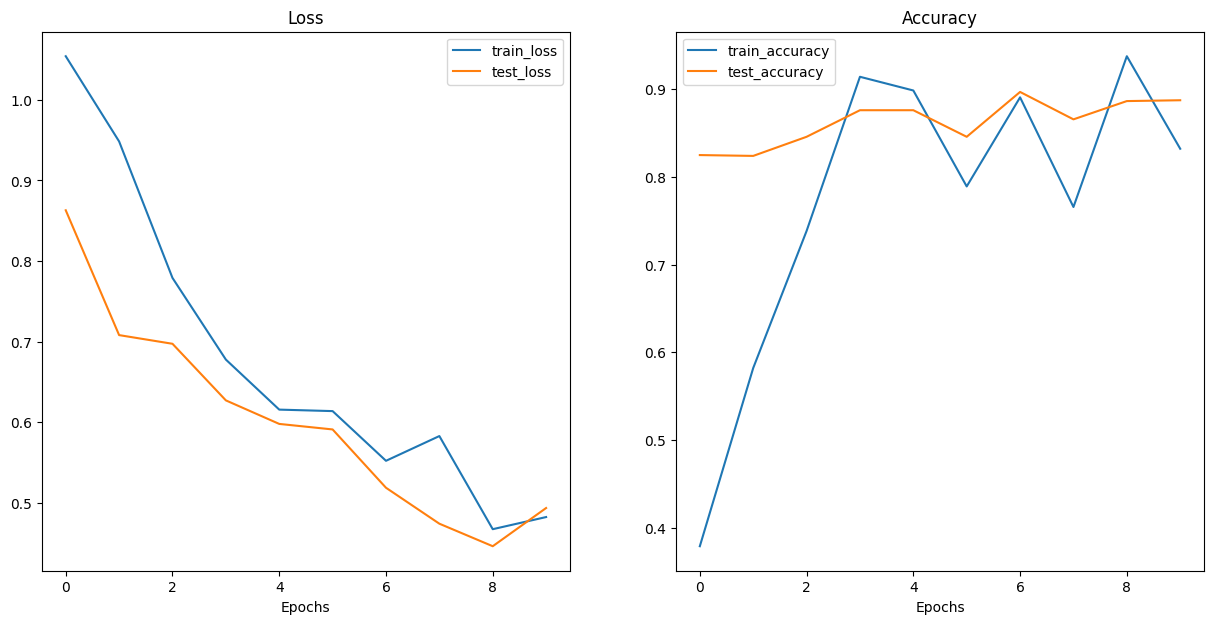

In [ ]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)
plot_loss_curves(results=model_0_results)